### Density

##### Calculating and plotting density decay

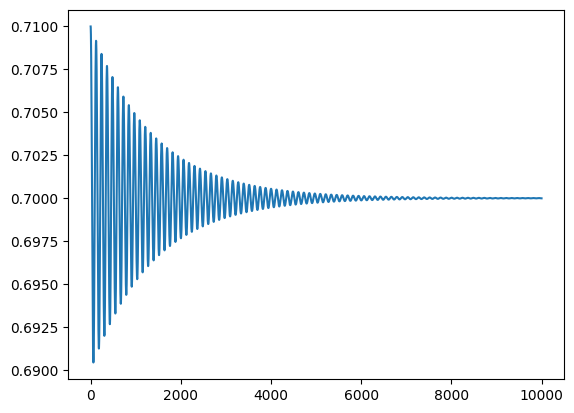

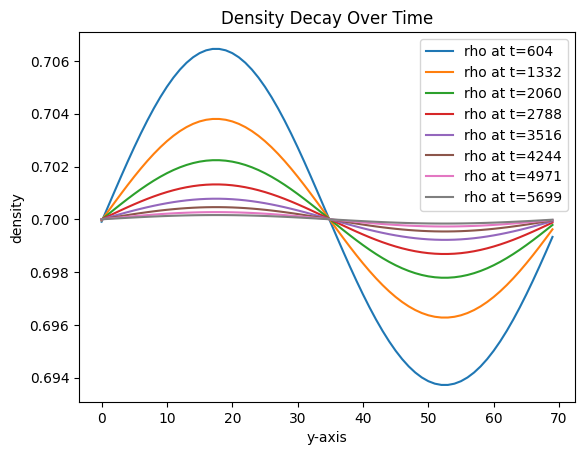

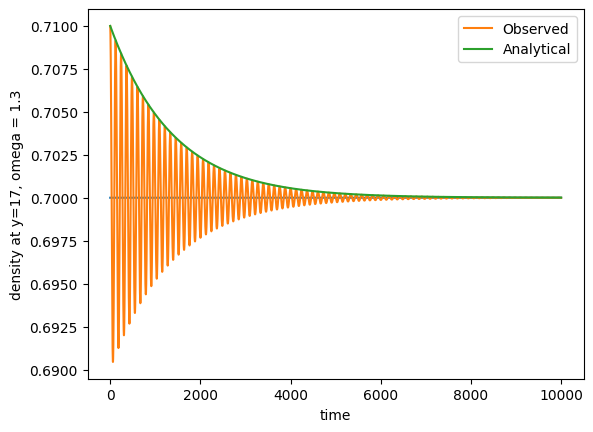

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

'''streaming function'''
def streaming_operator(f_inm, rho_nm, c_ai):
    rho_nm = np.einsum('ijk->jk', f_inm)
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift=c_ai.T[i], axis=(0, 1))
    return f_inm, rho_nm

'''equilibrium function'''
def feq(rho_nm, u_anm, c_ai, w_i):
    cu_nm = np.einsum('ai,anm->inm', c_ai, u_anm)
    sqcu_nm = cu_nm**2
    usq_nm = np.einsum('anm,anm->nm', u_anm, u_anm)
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    feq_inm = wrho_inm * (1 + 3 * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm)
    return feq_inm

'''collision function'''
def collision(f_inm, c_ai, w_i, omega):
    rho_nm = np.einsum('ijk->jk', f_inm)
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm) / rho_nm
    feq_ixy = feq(rho_nm, u_anm, c_ai, w_i)
    var = f_inm + omega * (feq_ixy - f_inm)
    return var, rho_nm


'''function to calculate perturbation formula'''
def perturbation(a0: float, e: float, v: np.ndarray, l: int, n: int) -> np.ndarray:
    return a0 + e * np.exp(-v * (2*np.pi/l)**2 * np.arange(n))


time_steps = 10000
grid_x, grid_y = 30, 70
omega = 1.3
epsilon = 0.01
rho_init = 0.7

'''setting density according to the sinusoidal wave formula in equation'''
density = rho_init + epsilon * np.sin(2 * np.pi * np.arange(grid_y)/grid_y)

'''initializing density field'''
rho_nm = np.tile(density, (grid_x, 1))

'''initializing velocity  field and pdf'''
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
c_ai = np.array([[ 0,  0, -1,  0,  1, -1, -1,  1,  1], [ 0,  1,  0, -1,  0,  1, -1, -1,  1]])
u_anm  = np.zeros((2, grid_x, grid_y))
f_inm = np.einsum('i,jk -> ijk', w_i, rho_nm) # defining the probability density function at each point of the grid
f_inm = feq(rho_nm, u_anm, c_ai, w_i)

'''using separate variable to record density at different time-steps'''
sine = np.empty((time_steps+1, grid_y))
sine[0] = rho_nm[0]

'''iterating through time-steps'''
for i in range(time_steps):
    f_inm, rho_nm = streaming_operator(f_inm, rho_nm, c_ai)
    f_inm, rho_nm = collision(f_inm, c_ai, w_i, omega)
    sine[i+1] = rho_nm[0]


'''additional plots used during testing for verification commented out'''
# plt.plot(sine)
# plt.show()
# print(sine.shape)

# for i in range(800):
#     plt.plot(sine[i])
# plt.show()

'''recording the peak of the first sine wave'''
peak = np.argmax(density)

'''isolating peaks'''
decay = sine[:, peak]

'''use argrelextrema to calculate relative extrema of 'decay'  '''
decay_inter = np.array([0], dtype=int)
decay_inter = np.append(decay_inter, argrelextrema(decay, np.greater)[0])

'''further validation commented'''
# print(decay.shape)
# print(measurement_point)
# print(decay_inter)

'''plotting peaks'''
plt.plot(decay)
plt.show()


fig, ax = plt.subplots()

i = 0

''''iterate through the isolated peaks'''
for i, j in enumerate(decay_inter[:50]):
  i+=1
  if i%6 == 0:
    ax.plot(sine[j], label=f"rho at t={j}")
    ax.set_title("Density Decay Over Time")
    ax.legend()
    ax.set_xlabel("y-axis")
    ax.set_ylabel("density")
''''''

plt.show()

'''calculate viscosity'''
viscosity = 1/3 * (1/omega - 0.5)
''''''

plt.figure()
plt.xlabel("time")
plt.ylabel(f"density at y={peak}, omega = {omega}")
plt.plot(np.ones_like(decay)*rho_init)
plt.plot(decay, label="Observed")

'''plotting analytical solution using the perturbation formula as defined in the function'''
plt.plot(perturbation(rho_init, epsilon, viscosity, grid_y, len(decay)), label="Analytical")

plt.legend()
plt.show()


##### comparing viscosities with varying omega against theoretical viscosity

In [66]:
omegas = [0.1, 0.3, 0.7, 0.9, 1.3, 1.5, 1.7]

'''initializing new decay variable to record decay for multiple omegas'''
decay = np.empty((len(omegas), time_steps+1))

'''storing viscosity for different omegas'''
viscosity_theoretical = np.empty((len(omegas)))

'''iterating through all omegas'''
for i, omega in enumerate(omegas):

    '''initializations for each omega'''
    u_anm  = np.zeros((2, grid_x, grid_y))
    rho_nm = np.tile(density, (grid_x, 1))
    peak = np.argmax(density)
    viscosity_theoretical[i] = 1/3 * (1/omega - 0.5)
    f_inm = np.einsum('i,jk -> ijk', w_i, rho_nm)
    f_inm = feq(rho_nm, u_anm, c_ai, w_i)
    decay[i, 0] = rho_nm[0, peak] - rho_init
    for j in range(time_steps):
        f_inm, rho_nm = streaming_operator(f_inm, rho_nm, c_ai)
        f_inm, rho_nm = collision(f_inm, c_ai, w_i, omega)
        decay[i, j+1] = rho_nm[0, peak] - rho_init

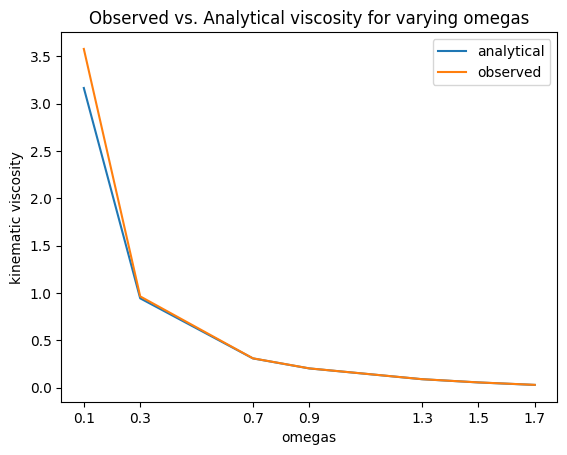

In [67]:
viscosity_observed = np.empty_like(viscosity_theoretical)

for i, omega in enumerate(omegas):
    '''
    here we use curve fit to fit a curve to the points corresponding to different omegas.
    We use v: epsilon * np.exp(-v * (2*np.pi/grid_x)**2 * t) to make 'v' the subject of the
    equation as given in a0.e[−ν(2πLz)]^2t.
    '''
    peak = np.append([0], argrelextrema(decay[i], np.greater)[0])
    viscosity_observed[i] = curve_fit(lambda t, v: epsilon * np.exp(-v * (2*np.pi/grid_y)**2 * t), xdata=peak, ydata=decay[i][peak])[0][0]

plt.title("Observed vs. Analytical viscosity for varying omegas")
plt.xlabel("omegas")
plt.ylabel("kinematic viscosity")
plt.xticks(omegas)
plt.plot(omegas, viscosity_theoretical, label="analytical")
plt.plot(omegas, viscosity_observed, label="observed")
plt.legend()
plt.show()

### Velocity

##### Calculating and plotting velocity decay

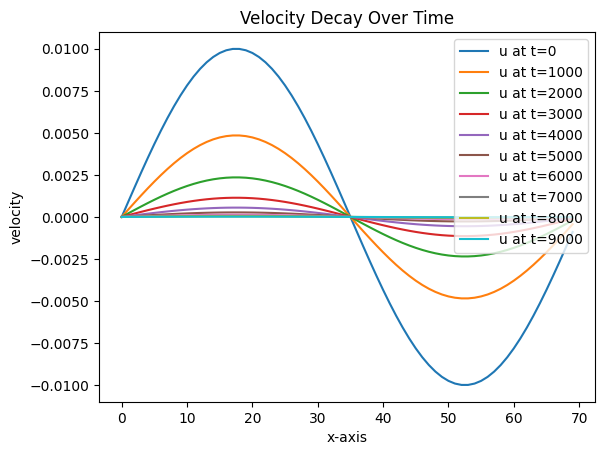

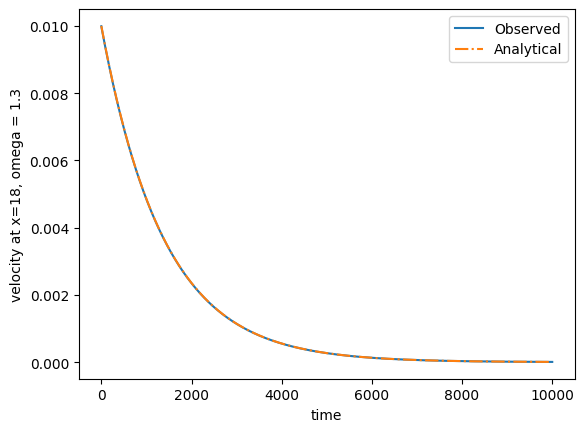

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

def streaming_operator(f_inm, rho_nm, c_ai):
    rho_nm = np.einsum('ijk->jk', f_inm)
    for i in range(9):
        f_inm[i] = np.roll(f_inm[i], shift=c_ai.T[i], axis=(0, 1))
    return f_inm, rho_nm

def feq(rho_nm, u_anm, c_ai, w_i):
    cu_nm = np.einsum('ai,anm->inm', c_ai, u_anm)
    sqcu_nm = cu_nm**2
    usq_nm = np.einsum('anm,anm->nm', u_anm, u_anm)
    wrho_inm = np.einsum('i,nm->inm', w_i, rho_nm)
    feq_inm = wrho_inm * (1 + 3 * cu_nm + 4.5 * sqcu_nm - 1.5 * usq_nm)
    return feq_inm

def collision(f_inm, c_ai, w_i, omega):
    rho_nm = np.einsum('ijk->jk', f_inm)
    u_anm  = np.einsum('ai,inm->anm', c_ai, f_inm) / rho_nm
    feq_ixy = feq(rho_nm, u_anm, c_ai, w_i)
    var = f_inm + omega * (feq_ixy - f_inm)
    return var, u_anm

def perturbation(a0: float, e: float, v: np.ndarray, l: int, n: int) -> np.ndarray:
    return a0 + e * np.exp(-v * (2*np.pi/l)**2 * np.arange(n))

time_steps = 10000
grid_x, grid_y = 70, 30
omega = 1.3
epsilon = 0.01

rho_nm = np.ones((grid_x, grid_y))

'''setting velocity according to sine wave formula'''
velocity = epsilon * np.sin(2 * np.pi * np.arange(grid_x)/grid_x)
u_anm = np.array([np.zeros((grid_x, grid_y)), np.tile(velocity[:, np.newaxis], (1, grid_y))])


w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
c_ai = np.array([[ 0,  0, -1,  0,  1, -1, -1,  1,  1], [ 0,  1,  0, -1,  0,  1, -1, -1,  1]])
f_inm = np.einsum('i,jk -> ijk', w_i, rho_nm)
f_inm = feq(rho_nm, u_anm, c_ai, w_i)

'''We follow the same procedure of saving peaks like in the density case. 
   We isolate peaks and plot the decay.'''

sine = np.empty((time_steps+1, grid_x))
sine[0] = u_anm[1, :, 0]
peak = np.argmax(velocity)
decay = sine[:, peak]

'''use argrelextrema to calculate relative extrema of 'decay'''
decay_inter = np.array([0], dtype=int)
decay_inter = np.append(decay_inter, argrelextrema(decay, np.greater)[0])
frames = np.unique((np.arange(time_steps**(1/np.e), step=0.5)**np.e).astype(int))
n_cols = 12
n_rows = len(frames)//n_cols

'''running simulation over time-steps'''
for i in range(time_steps):
    f_inm, rho_nm = streaming_operator(f_inm, rho_nm, c_ai)
    f_inm, u_anm = collision(f_inm, c_ai, w_i, omega)
    sine[i+1] = u_anm[1, :, 0]

# for i in range(5000):
#     plt.plot(sine[i])
# plt.show()

fig, ax = plt.subplots()

for i in range(time_steps):
  if i % 1000 == 0:
    ax.plot(sine[i], label=f"u at t={i}")
    ax.set_title(f"Velocity Decay Over Time")
    ax.legend()
    ax.set_xlabel("x-axis")
    ax.set_ylabel("velocity")

plt.show()

'''calculate viscosity'''
viscosity = 1/3 * (1/omega - 0.5)
''''''

plt.figure()
plt.xlabel("time")
plt.ylabel(f"velocity at x={peak}, omega = {omega}")

plt.plot(decay, label="Observed")
plt.plot(perturbation(0, epsilon, viscosity, grid_x, time_steps),linestyle="-.", label="Analytical")
plt.legend()
plt.show()